In [57]:
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits 
%matplotlib widget

In [58]:
K2_KSFF_c12 = np.genfromtxt('hlsp_k2sff_k2_lightcurve_246393474-c12_kepler_v1_llc/hlsp_k2sff_k2_lightcurve_246393474-c12_kepler_v1_llc-default-aper.txt', skip_header=1, delimiter=',')  
c12_time = 54833. + K2_KSFF_c12[:,0]
c12_flux = K2_KSFF_c12[:,1]
diff = c12_flux[1:] - c12_flux[:-1]
c12_ferr = np.ones_like(c12_flux) * np.std(diff) / np.sqrt(2)

K2_KSFF_c19 = np.genfromtxt('hlsp_k2sff_k2_lightcurve_246393474-c19_kepler_v1_llc/hlsp_k2sff_k2_lightcurve_246393474-c19_kepler_v1_llc-default-aper.txt', skip_header=1, delimiter=',')  
c19_time = 54833. + K2_KSFF_c19[:,0]
c19_flux = K2_KSFF_c19[:,1]
diff = c19_flux[1:] - c19_flux[:-1]
c19_ferr = np.ones_like(c19_flux) * np.std(diff) / np.sqrt(2)

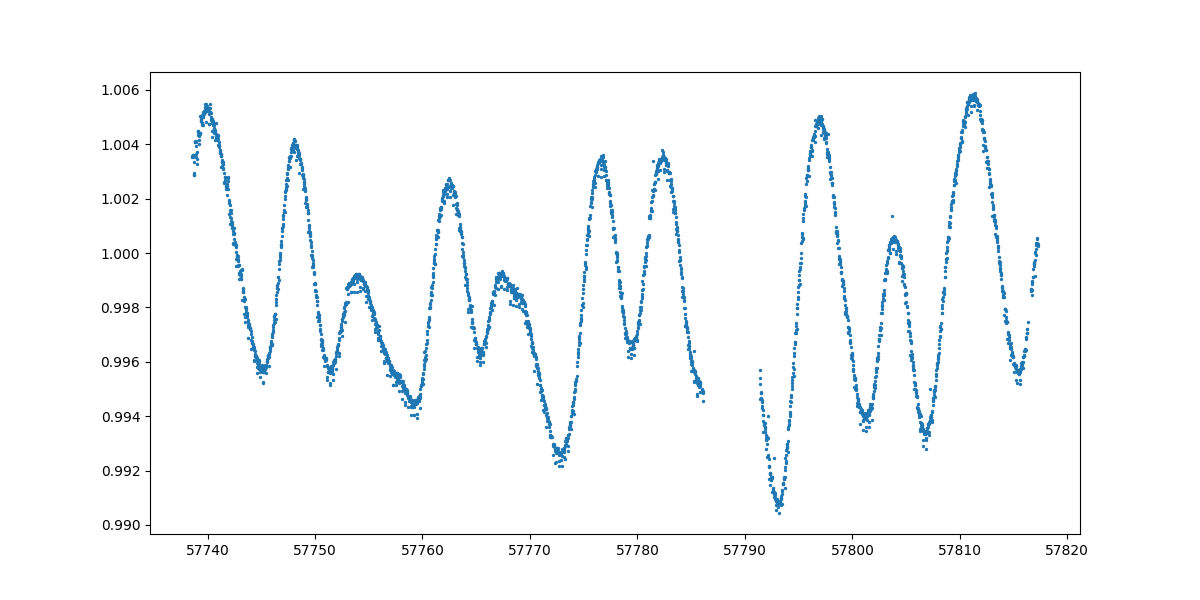

In [59]:
plt.figure(figsize=(12,6))
plt.scatter(c12_time, c12_flux, s=2)
plt.show()
#plt.scatter(c19_time, c19_flux, s=2)
#c19_flux

# Planetary parameters
We need fairly precise values for the orbital parameters: period, T0 (as close as possible to the TESS time stamps).
We also need to define:
- a window around the centre of the transit (in the folded space): we use the points inside this window to estimate the planetary parameters
- the length of each bin (binning step)

Only the points outside the window will be binned. The binning step must be large enough to produce a sensible decrease in the umber of data points, to speed up the GP compuation and avoid memory hogs, but not too large to smooth out stellar signals. 


In [60]:
# K2-141b
p0_T0 = 60232.513071
p0_P = 0.2803244

#K2-141c
p1_T0 = 57751.15460
p1_P = 7.74850
window_for_transit_fit = 4.0 / 24. # expressed in days
binning_step = 1200. / 86400. # expressed in days



In [61]:
from scipy.stats import binned_statistic

def bin_lightcurve(BJD, LC_val, LC_err):
    
    #only_transits
    p0_phase_folded = ((BJD-p0_T0-p0_P/2) % p0_P ) - p0_P/2
    p0_outtransit_sel = np.abs(p0_phase_folded) > window_for_transit_fit/2.
    
    p1_phase_folded = ((BJD-p1_T0-p1_P/2) % p1_P ) - p1_P/2
    p1_outtransit_sel = np.abs(p1_phase_folded) > window_for_transit_fit/2.
    
    outtransit_sel = p0_outtransit_sel & p1_outtransit_sel
    
    time = BJD[outtransit_sel]
    flux = LC_val[outtransit_sel]
    ferr = LC_err[outtransit_sel]
    
    time_transit = BJD[~outtransit_sel]
    flux_transit = LC_val[~outtransit_sel]
    ferr_transit = LC_err[~outtransit_sel]
    flag_transit = np.ones_like(ferr_transit) ####
    
    time_array = np.arange(time[0], time[-1], binning_step)
    indices = np.digitize(time, time_array)
    
    time_bins, _, _ = binned_statistic(time, time, bins=time_array, statistic='mean')
    flux_bins, _, _ = binned_statistic(time, flux, bins=time_array, statistic='mean')
    fer2_bins, _, _ = binned_statistic(time, ferr**2, bins=time_array, statistic='sum')
    flux_counts, _, _ = binned_statistic(time, time, bins=time_array, statistic='count')
    
    ferr_bins = np.sqrt(fer2_bins)/ flux_counts
    time_binned = time_bins[flux_counts>5]
    flux_binned = flux_bins[flux_counts>5]
    ferr_binned = ferr_bins[flux_counts>5]
    flag_binned = np.zeros_like(ferr_binned) #### 
    
    plt.figure(figsize=(12,8))
    plt.errorbar(time, flux, yerr=ferr, color='C0', alpha=0.2, fmt='o', ms=2, label='Original data')
    plt.errorbar(time_binned, flux_binned, color='C1', yerr=ferr_binned, fmt='o', ms=2, label='Binned data')
    plt.scatter(time_transit, flux_transit, s=2, c='C6', zorder=10, label='In-transit data')
    plt.xlabel('BJD_TDB [d]')
    plt.ylabel('Rescaled flux')
    plt.legend()
    plt.show()
    
    time_temp = np.concatenate((time_binned, time_transit))
    flux_temp = np.concatenate((flux_binned, flux_transit))
    ferr_temp = np.concatenate((ferr_binned, ferr_transit))
    flag_temp = np.concatenate((flag_binned, flag_transit)) ####
    
    index_temp = np.argsort(time_temp)
    
    time_season_binned = time_temp[index_temp]
    flux_season_binned = flux_temp[index_temp]
    ferr_season_binned = ferr_temp[index_temp]
    flag_season_binned = flag_temp[index_temp] ####

    return time_season_binned, flux_season_binned, ferr_season_binned,  flag_season_binned

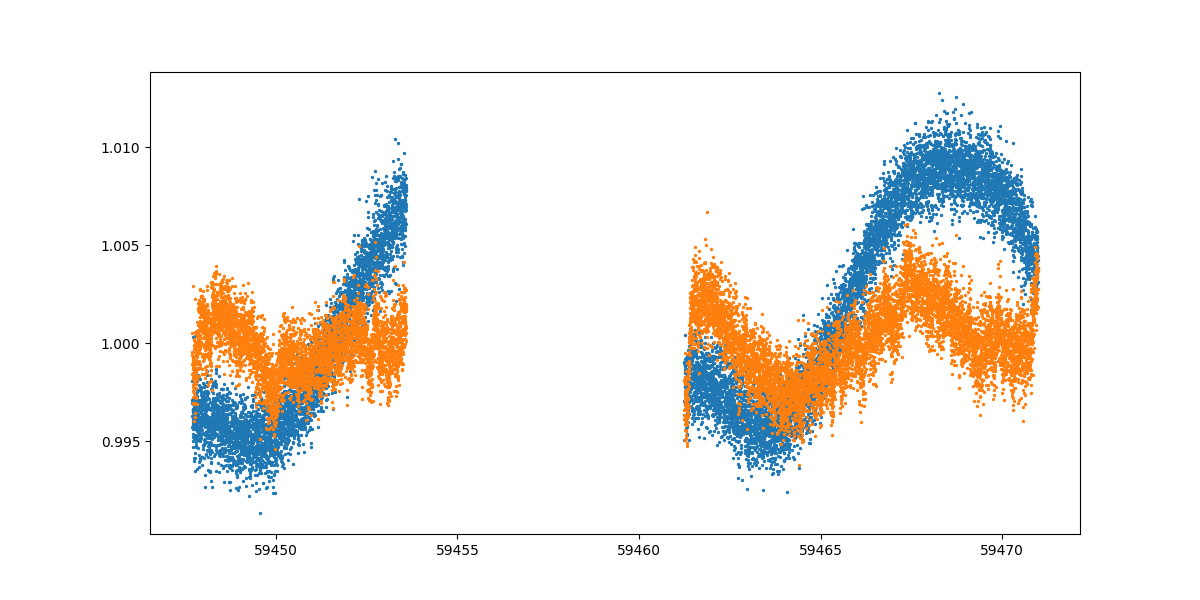

11236


/tmp/ipykernel_13201/1239703874.py:31: RuntimeWarning: invalid value encountered in divide
  ferr_bins = np.sqrt(fer2_bins)/ flux_counts


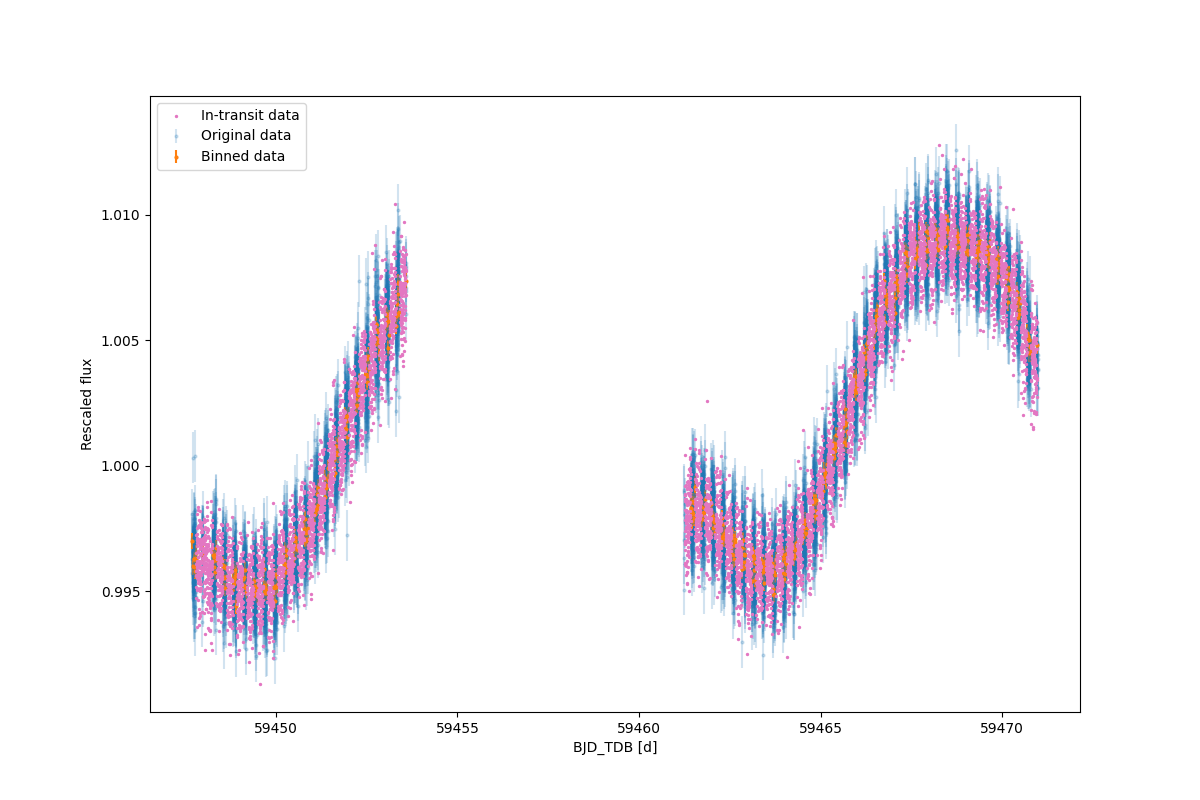

In [62]:
# This is an example of bit selection, it may not apply to your case
flags_to_be_checked = np.array([1,2,3,4,5,6,8,10,13,15])
reference_bitmask_in_decimal_system = 0
for v in flags_to_be_checked:
    reference_bitmask_in_decimal_system += 2**(v-1)

s42_fits = fits.open('tess2021232031932-s0042-0000000301235044-0213-s/tess2021232031932-s0042-0000000301235044-0213-s_lc.fits')

finite_selection = np.isfinite(s42_fits[1].data['PDCSAP_FLUX'])

quality_bitmask = s42_fits[1].data['QUALITY']
selective_selection = ~(np.bitwise_and(quality_bitmask, reference_bitmask_in_decimal_system) > 0) & finite_selection


s42_time = s42_fits[1].data['TIME'][selective_selection] + 57000
s42_sap_flux = s42_fits[1].data['SAP_FLUX'][selective_selection]
s42_sap_ferr = s42_fits[1].data['SAP_FLUX_ERR'][selective_selection]
s42_pdcsap_flux = s42_fits[1].data['PDCSAP_FLUX'][selective_selection]
s42_pdcsap_ferr = s42_fits[1].data['PDCSAP_FLUX_ERR'][selective_selection]

plt.figure(figsize=(12,6))
plt.scatter(s42_time, s42_sap_flux/np.median(s42_sap_flux), s=2)
plt.scatter(s42_time, s42_pdcsap_flux/np.median(s42_pdcsap_flux), s=2)
plt.show()

print(len(s42_time))


s42_time_season_binned, s42_flux_season_binned, s42_ferr_season_binned,  s42_flag_season_binned = bin_lightcurve(s42_time, s42_sap_flux/np.median(s42_sap_flux), s42_sap_ferr/np.median(s42_sap_flux))

In [63]:
s42_fits[1].columns 


ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; u

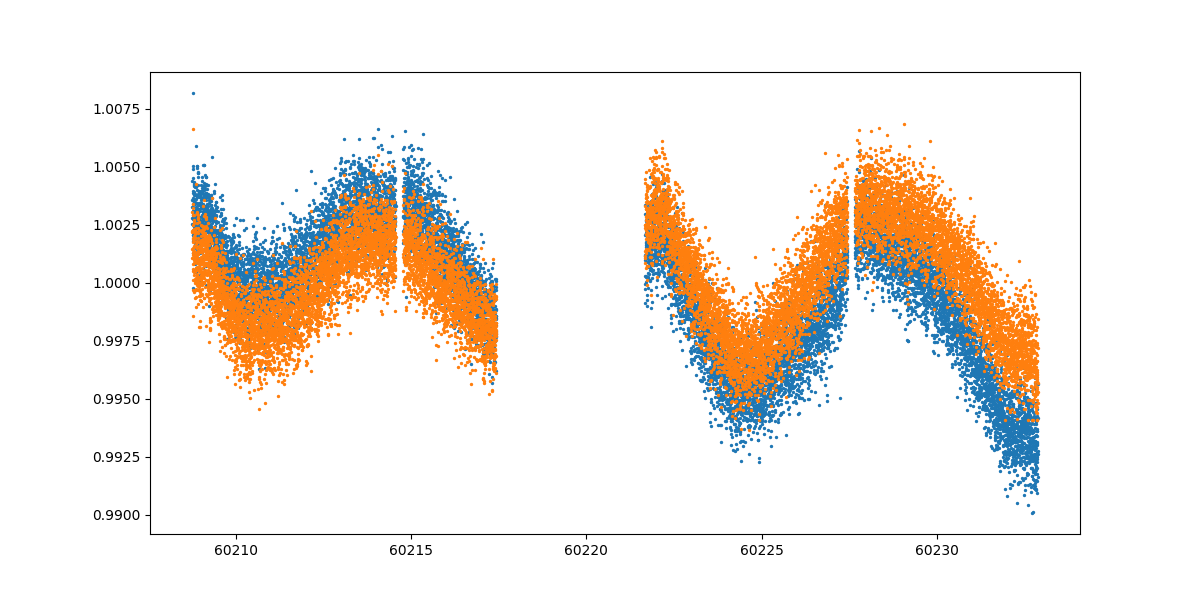

14014


/tmp/ipykernel_13201/1239703874.py:31: RuntimeWarning: invalid value encountered in divide
  ferr_bins = np.sqrt(fer2_bins)/ flux_counts


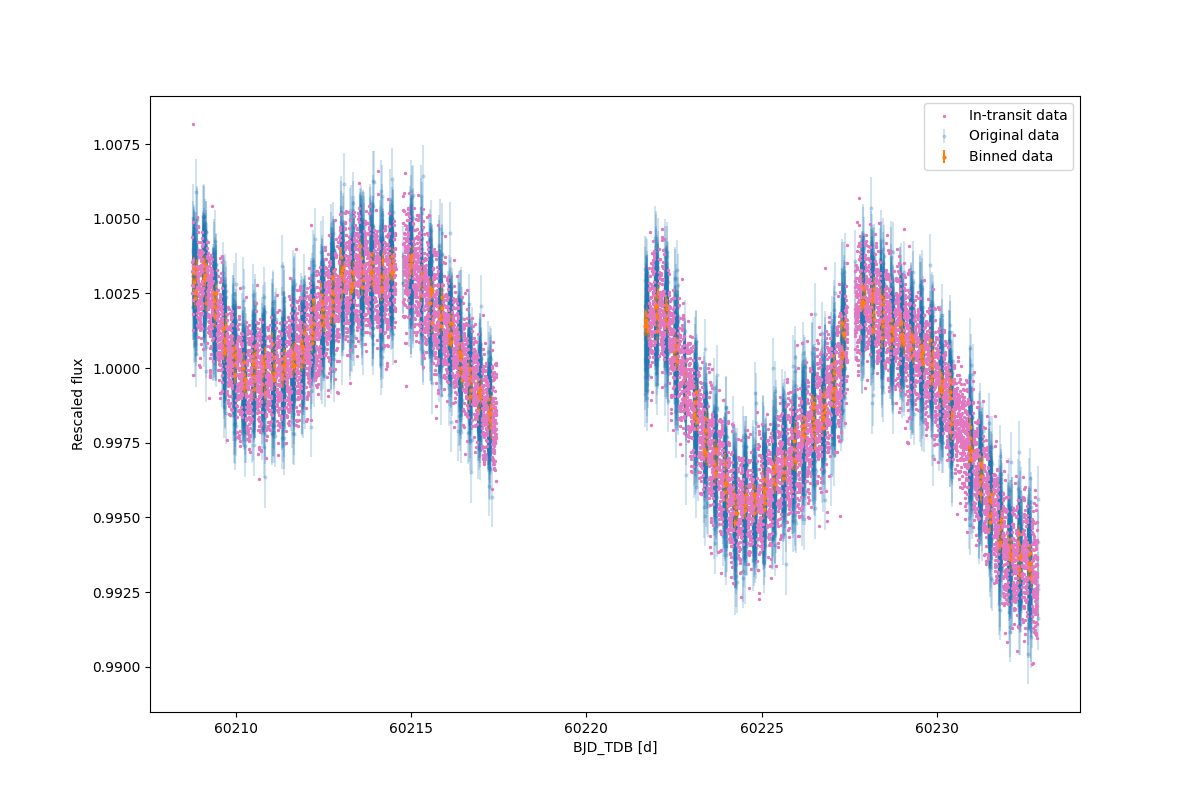

In [64]:
s70_fits = fits.open('tess2023263165758-s0070-0000000301235044-0265-s/tess2023263165758-s0070-0000000301235044-0265-s_lc.fits')

finite_selection = np.isfinite(s70_fits[1].data['PDCSAP_FLUX'])

quality_bitmask = s70_fits[1].data['QUALITY']
selective_selection = ~(np.bitwise_and(quality_bitmask, reference_bitmask_in_decimal_system) > 0) & finite_selection


s70_time = s70_fits[1].data['TIME'][selective_selection] + 57000.
s70_sap_flux = s70_fits[1].data['SAP_FLUX'][selective_selection]
s70_sap_ferr = s70_fits[1].data['SAP_FLUX_ERR'][selective_selection]
s70_pdcsap_flux = s70_fits[1].data['PDCSAP_FLUX'][selective_selection]
s70_pdcsap_ferr = s70_fits[1].data['PDCSAP_FLUX_ERR'][selective_selection]


plt.figure(figsize=(12,6))
plt.scatter(s70_time, s70_sap_flux/np.median(s70_sap_flux), s=2)
plt.scatter(s70_time, s70_pdcsap_flux/np.median(s70_pdcsap_flux), s=2)
plt.show()
print(len(s70_time))

s70_time_season_binned, s70_flux_season_binned, s70_ferr_season_binned,  s70_flag_season_binned = bin_lightcurve(s70_time, s70_sap_flux/np.median(s70_sap_flux), s70_sap_ferr/np.median(s70_sap_flux))

In [65]:
fileout = open('K2-141_K2_KSFF_PyORBIT.dat', 'w')
for tt, ff, ee in zip(c12_time, c12_flux, c12_ferr):
    fileout.write('{0:12.6f} {1:12.6f} {2:12.6f} 0 -1 -1 \n'.format(tt, ff,ee))
fileout.close()

fileout = open('K2-141_TESS_s42_PyORBIT.dat', 'w')
for tt, ff, ee in zip(s42_time, s42_sap_flux/np.median(s42_sap_flux), s42_sap_ferr/np.median(s42_sap_flux)):
    fileout.write('{0:12.6f} {1:12.6f} {2:12.6f} 0 -1 -1 \n'.format(tt, ff,ee))
fileout.close()

fileout = open('K2-141_TESS_s70_PyORBIT.dat', 'w')
for tt, ff, ee in zip(s70_time, s70_sap_flux/np.median(s70_sap_flux), s70_sap_ferr/np.median(s70_sap_flux)):
    fileout.write('{0:12.6f} {1:12.6f} {2:12.6f} 0 -1 -1 \n'.format(tt, ff,ee))
fileout.close()

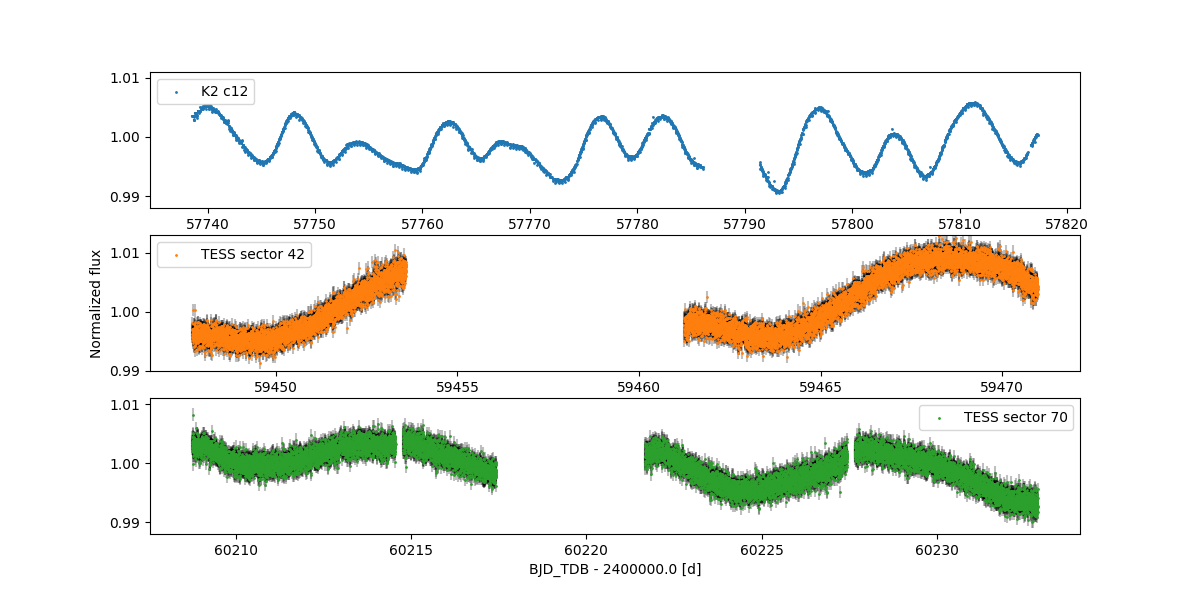

In [83]:
fig, ax = plt.subplots(3, figsize=(12,6))
ax[0].scatter(c12_time, c12_flux, c='C0', s=1, label='K2 c12')
ax[0].errorbar(c12_time, c12_flux, yerr=c12_ferr, fmt=' ', c='k', alpha=0.25, zorder = -1)
ax[0].legend()
ax[0].set_ylim(0.988, 1.011)

ax[1].scatter(s42_time, s42_sap_flux/np.median(s42_sap_flux), c='C1', s=1, label='TESS sector 42')
ax[1].errorbar(s42_time, s42_sap_flux/np.median(s42_sap_flux), yerr=s42_sap_ferr/np.median(s42_sap_flux), fmt=' ', c='k', alpha=0.25, zorder = -1)
ax[1].legend()
ax[1].set_ylim(0.990, 1.013)
ax[1].set_ylabel('Normalized flux')

ax[2].scatter(s70_time, s70_sap_flux/np.median(s70_sap_flux), c='C2', s=1, label='TESS sector 70')
ax[2].errorbar(s70_time, s70_sap_flux/np.median(s70_sap_flux), yerr=s70_sap_ferr/np.median(s70_sap_flux), fmt=' ', c='k', alpha=0.25, zorder = -1)
ax[2].legend()
ax[2].set_ylim(0.988, 1.011)
ax[2].set_xlabel('BJD_TDB - 2400000.0 [d]')

plt.savefig('K2-141_lightcurves.png', dpi=200)